# Deep-learning Nodule Segmentation using LIDC dataset on Google Cloud Platform (GCP). 

## Part 1: Preprocessing LIDC data with BigQuery and cohort manifest.

Package install (for the first time execution):

In [ ]:
!pip install KevinSR
!pip install pylidc
!conda install pydicom --channel conda-forge
!pip install torchsummary
!pip install segmentation_models_pytorch

Import packages: 

In [133]:
import pandas as pd
import os, json
import time
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
import random
import pydicom
import pylidc as pl
from pylidc.utils import consensus
from skimage.measure import find_contours
from KevinSR import mask_interpolation
from scipy.ndimage import zoom
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import torchvision
import segmentation_models_pytorch as smp

%matplotlib notebook 

def get_idc_viewer_url(studyUID):
    return "https://viewer.imaging.datacommons.cancer.gov/viewer/"+studyUID

Assign the configured GCP project ID under your account:

In [2]:
myProjectID = "idc-external-005"
#pd.set_option('display.max_colwidth',300)
#pd.set_option('display.max_rows', None)

Data exploration using BigQuery by IDC:

In [3]:
%%bigquery --project=$myProjectID CT_series

WITH
  all_lidc_ct_series AS (
  SELECT
    DISTINCT(SeriesInstanceUID),
    StudyInstanceUID,  
    PatientID,
    SliceThickness,
    ARRAY_TO_STRING(PixelSpacing,"/") as pixelspa 
  FROM
    `canceridc-data.idc_views.dicom_all`
  WHERE
    Modality = "CT"
    AND collection_id = "lidc_idri")
SELECT PatientID,SliceThickness,pixelspa,StudyInstanceUID,SeriesInstanceUID FROM
  all_lidc_ct_series
ORDER BY
  PatientID    

As an example, show metadata of the first three patients:

In [17]:
#pd.reset_option('all')
CT_series[CT_series['PatientID'].isin(['LIDC-IDRI-0001','LIDC-IDRI-0002', 'LIDC-IDRI-0003'])]

,PatientID,SliceThickness,pixelspa,StudyInstanceUID,SeriesInstanceUID
0,LIDC-IDRI-0001,2.500000,0.703125/0.703125,1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288...,1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636...
1,LIDC-IDRI-0002,1.250000,0.681641/0.681641,1.3.6.1.4.1.14519.5.2.1.6279.6001.490157381160...,1.3.6.1.4.1.14519.5.2.1.6279.6001.619372068417...
2,LIDC-IDRI-0003,2.500000,0.820312/0.820312,1.3.6.1.4.1.14519.5.2.1.6279.6001.101370605276...,1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615...


The pd table obtained by IDC BigQuery contains one row per DICOM instance. We can use BigQuery to extract various aspects of the dataset, and selectively analyze/filter interesting features based on meta data. 

For instance, we can examine the heterogeneity of acquisition and plot the data distributions in terms of slice thickness and pixel spacing: 

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 0, 'PixelSpacing, mm')]

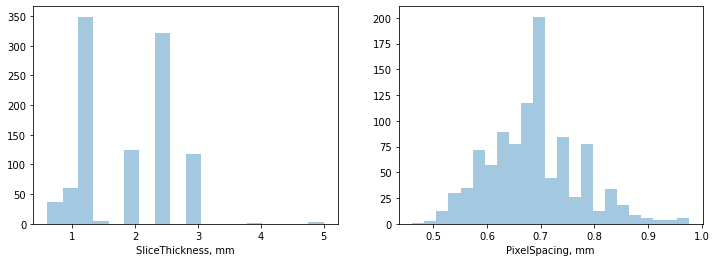

In [18]:
%matplotlib inline
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
ax=sb.distplot(CT_series["SliceThickness"].astype(float),kde=False)
ax.set(xlabel="SliceThickness, mm")

plt.subplot(1,2,2)
xSpacing = CT_series["pixelspa"].str.split('/',n=1,expand=True)[0].astype(float)
ax=sb.distplot(xSpacing, kde=False)
ax.set(xlabel="PixelSpacing, mm")


Image data itself can be viewed by IDC Viewer described here, or can be downloaded with the help of cohort manifest.   

In [20]:
print(get_idc_viewer_url(CT_series["StudyInstanceUID"][0]))

https://viewer.imaging.datacommons.cancer.gov/viewer/1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288633453246975630178


#### With the help of BQ metadata table, we don't have to download the whole LIDC data. DICOM files can be selectively downloaded in a systematic way that we first define the conditions to filter the dataset, and then build the corresponding manifest file to download. The conditions can be defined in terms of any features or requirements based on the acquired metadata.    

Here, as an example, we filter LIDC based on the feature: "SliceThickness". The data was grouped as "SliceThickness" equal to 1 mm, 2 mm and 3 mm. The example cohort was built by including 5 scans from each group. In sum, we collected 15 scans with different slice thicknesses.  

In [4]:
s_1,s_2,s_3 = 5,5,5
ct_series_1 = CT_series[CT_series["SliceThickness"].astype(float)==1.0]
ct_series_2 = CT_series[CT_series["SliceThickness"].astype(float)==2.0]
ct_series_3 = CT_series[CT_series["SliceThickness"].astype(float)==3.0]
ct_series_HR = pd.concat([ct_series_1[:s_1],ct_series_2[:s_2],ct_series_3[:s_3]])
#ct_series_HR = CT_series[CT_series["PatientID"].isin(["LIDC-IDRI-0001",'LIDC-IDRI-0002','LIDC-IDRI-0003'])]

BigQuery table for the collection (15 scans): 

In [5]:
ct_series_HR

,PatientID,SliceThickness,pixelspa,StudyInstanceUID,SeriesInstanceUID
298,LIDC-IDRI-0298,1,0.64453125/0.64453125,1.3.6.1.4.1.14519.5.2.1.6279.6001.135045503670...,1.3.6.1.4.1.14519.5.2.1.6279.6001.326057189095...
300,LIDC-IDRI-0300,1,0.6640625/0.6640625,1.3.6.1.4.1.14519.5.2.1.6279.6001.165017330457...,1.3.6.1.4.1.14519.5.2.1.6279.6001.324290109423...
314,LIDC-IDRI-0314,1.0,0.78125/0.78125,1.3.6.1.4.1.14519.5.2.1.6279.6001.265704884949...,1.3.6.1.4.1.14519.5.2.1.6279.6001.154677396354...
326,LIDC-IDRI-0325,1.0,0.8125/0.8125,1.3.6.1.4.1.14519.5.2.1.6279.6001.815399168774...,1.3.6.1.4.1.14519.5.2.1.6279.6001.725023183844...
347,LIDC-IDRI-0345,1,0.546875/0.546875,1.3.6.1.4.1.14519.5.2.1.6279.6001.311849240521...,1.3.6.1.4.1.14519.5.2.1.6279.6001.387954549120...
68,LIDC-IDRI-0069,2.0,0.741/0.741,1.3.6.1.4.1.14519.5.2.1.6279.6001.303241414168...,1.3.6.1.4.1.14519.5.2.1.6279.6001.131939324905...
83,LIDC-IDRI-0084,2.0,0.705/0.705,1.3.6.1.4.1.14519.5.2.1.6279.6001.198480745206...,1.3.6.1.4.1.14519.5.2.1.6279.6001.288701997968...
93,LIDC-IDRI-0094,2,0.736328125/0.736328125,1.3.6.1.4.1.14519.5.2.1.6279.6001.292294220516...,1.3.6.1.4.1.14519.5.2.1.6279.6001.143622857676...
94,LIDC-IDRI-0095,2,0.599609375/0.599609375,1.3.6.1.4.1.14519.5.2.1.6279.6001.234289514191...,1.3.6.1.4.1.14519.5.2.1.6279.6001.137773550852...
105,LIDC-IDRI-0106,2.0,0.698/0.698,1.3.6.1.4.1.14519.5.2.1.6279.6001.119329123269...,1.3.6.1.4.1.14519.5.2.1.6279.6001.712472578497...


Then, we prepare the manifest table for the collection:

In [113]:
to_download = []
base_gs_uri = 'gs://idc-tcia-lidc-idri/dicom/'

for i in range(ct_series_HR.shape[0]):
    to_download.append(base_gs_uri + ct_series_HR.iloc[i]['StudyInstanceUID'] + '/' + ct_series_HR.iloc[i]['SeriesInstanceUID'])

manifest_df = pd.DataFrame({"gcs":to_download},columns=["gcs"])

In [114]:
manifest_df

,gcs
0,gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.135045503670480596826162811572/1.3.6.1.4.1.14519.5.2.1.6279.6001.326057189095429101398977448288
1,gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.165017330457520545748655969705/1.3.6.1.4.1.14519.5.2.1.6279.6001.324290109423920971676288828329
2,gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.265704884949271879044145982159/1.3.6.1.4.1.14519.5.2.1.6279.6001.154677396354641150280013275227
3,gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.815399168774050638734383723372/1.3.6.1.4.1.14519.5.2.1.6279.6001.725023183844147505748475581290
4,gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.311849240521371267537044867782/1.3.6.1.4.1.14519.5.2.1.6279.6001.387954549120924524005910602207
5,gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.303241414168367763244410429787/1.3.6.1.4.1.14519.5.2.1.6279.6001.131939324905446238286154504249
6,gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.198480745206106280149820227940/1.3.6.1.4.1.14519.5.2.1.6279.6001.288701997968615460794642979503
7,gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.292294220516976158142911380662/1.3.6.1.4.1.14519.5.2.1.6279.6001.143622857676008763729469324839
8,gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.234289514191030145998276287188/1.3.6.1.4.1.14519.5.2.1.6279.6001.137773550852881583165286615668
9,gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.119329123269319944171115250782/1.3.6.1.4.1.14519.5.2.1.6279.6001.712472578497712558367294720243


Save the cohort manifest as a txt file to be ready for download. 

(For reference, another way to prepare the manifest file is visiting the website: https://portal.imaging.datacommons.cancer.gov/. And select the collection, save the cohort, and export the cohort manifest. But, by this way the filtering function provided on the website is very limited so far.)  

In [121]:
manifest_df.to_csv("gcs_paths_3.txt",header=False, index=False)
!head gcs_paths_3.txt

gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.135045503670480596826162811572/1.3.6.1.4.1.14519.5.2.1.6279.6001.326057189095429101398977448288
gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.165017330457520545748655969705/1.3.6.1.4.1.14519.5.2.1.6279.6001.324290109423920971676288828329
gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.265704884949271879044145982159/1.3.6.1.4.1.14519.5.2.1.6279.6001.154677396354641150280013275227
gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.815399168774050638734383723372/1.3.6.1.4.1.14519.5.2.1.6279.6001.725023183844147505748475581290
gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.311849240521371267537044867782/1.3.6.1.4.1.14519.5.2.1.6279.6001.387954549120924524005910602207
gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.303241414168367763244410429787/1.3.6.1.4.1.14519.5.2.1.6279.6001.131939324905446238286154504249
gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.

Download the data collection through cohort manifest:

In [ ]:
!mkdir downloaded_cohort_3
!cat gcs_paths_3.txt | gsutil -u $myProjectID -m cp -Ir ./downloaded_cohort_3

Organize the downloaded DICOMs with the package "dicomsort":

In [ ]:
!git clone https://github.com/pieper/dicomsort.git
!pip install pydicom
!python dicomsort/dicomsort.py --help

In [123]:
!python dicomsort/dicomsort.py -u downloaded_cohort_3 cohort_sorted_3/%PatientID/%StudyInstanceUID/%SeriesInstanceUID/%SOPInstanceUID.dcm

100%|██████████████████████████████████████| 3448/3448 [00:07<00:00, 474.77it/s]
Files sorted


OK, DICOMs are ready and stored at the address "data_folder" named here:

In [6]:
data_folder = os.getcwd() + '/cohort_sorted_3/'
data_folder

'/home/jupyter/cohort_sorted_3/'

We are going to view the data by loading DICOMs with Pydicom and also look into the way to associate the nodule segmentation data using pylidc. First, we need to create a .pylidcrc file:

In [128]:
f = open ('.pylidcrc','w')
f.write('[dicom]'+'\n')
f.write('path = data_folder +'\n')
f.write('warn = True')
f.close()

Visualize the image, and compare it with the mask. The nodule contours are shown as the third column. By modifing "patient_select", we can see different scans within our collected data. Multiple nodules may exist for some scans. Thus, for any viewed scan, the number of rows is equal to the number of nodules labeled.  

Current patient ID = LIDC-IDRI-0079
Loading dicom files ... This may take a moment.


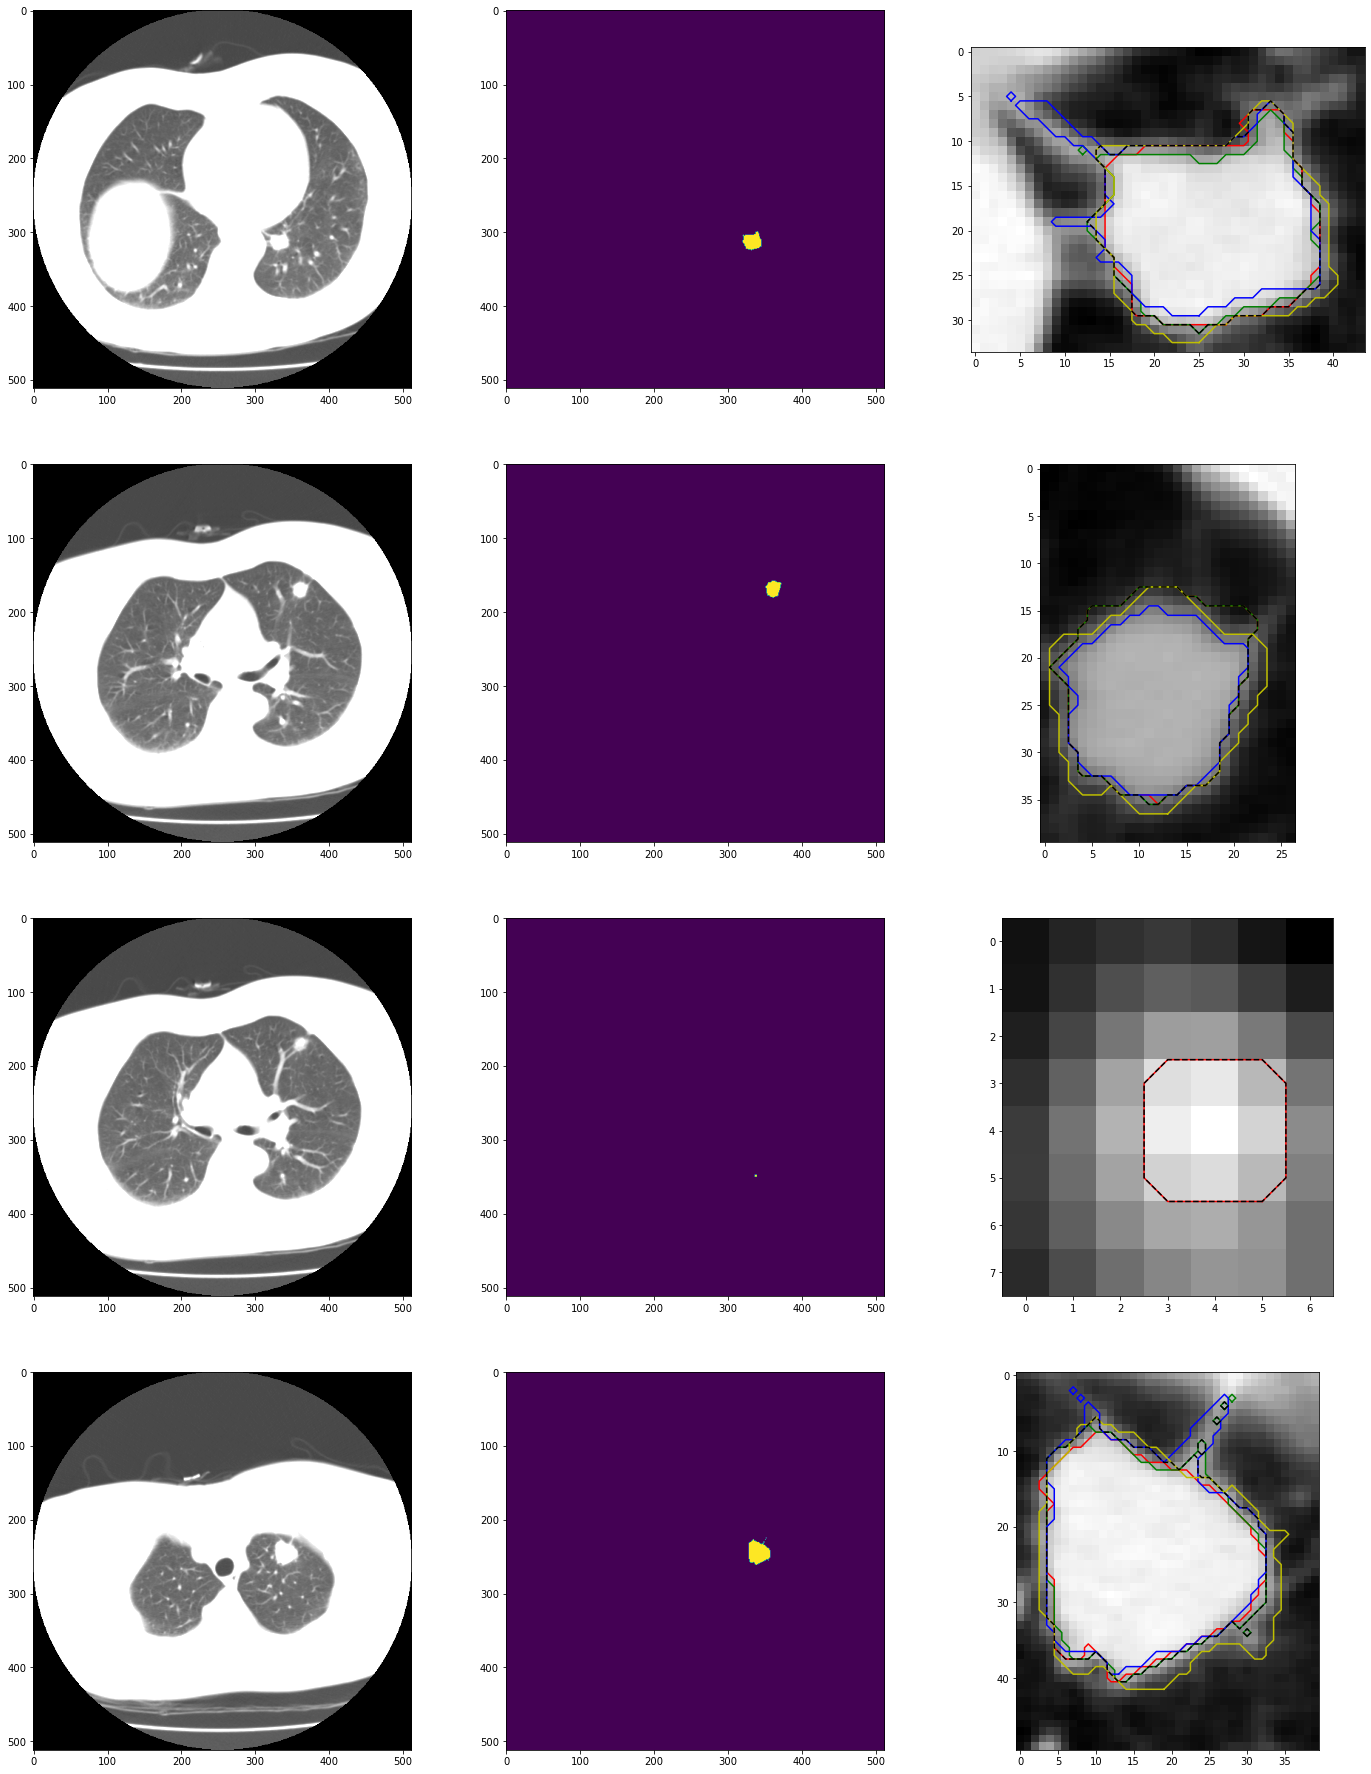

In [7]:
%matplotlib inline

cohort = data_folder
patient_list = os.listdir(cohort)
patient_select = 0

print ("Current patient ID =", patient_list[patient_select])

scan = pl.query(pl.Scan).filter(pl.Scan.patient_id.in_(patient_list))
nodules_annotation = scan[patient_select].cluster_annotations()
vol = scan[patient_select].to_volume()

cmask_CT = []
cbbox_CT = []
masks_CT = []
for nodule_idx, nodule in enumerate(nodules_annotation):
    cmask, cbbox, masks = consensus(nodule)
    cmask_CT.append(cmask)
    cbbox_CT.append(cbbox)
    masks_CT.append(masks)   

nodule_num = len(cmask_CT)
plt.figure(figsize=(8*3,8*nodule_num))
for i in range(nodule_num):
    cmask = cmask_CT[i]
    cbbox = cbbox_CT[i]
    masks = masks_CT[i]
    k = int(0.5*(cbbox[2].stop - cbbox[2].start))
    k_slice = k + cbbox[2].start
    plt.subplot(nodule_num,3,1+i*3)
    plt.imshow(vol[:,:,k_slice],cmap='gray')
    plt.clim(vmin=-1350,vmax=-150)
    
    plt.subplot(nodule_num,3,2+i*3)
    CT_mask = np.zeros_like(vol)
    CT_mask[cbbox] = cmask
    plt.imshow(CT_mask[:,:,k_slice])

    plt.subplot(nodule_num,3,3+i*3)
    plt.imshow(vol[cbbox][:,:,k],cmap='gray')
    # Plot the annotation contours for the kth slice.
    colors = ['r', 'g', 'b', 'y']
    for j in range(len(masks)):
        for c in find_contours(masks[j][:,:,k].astype(float), 0.5):
            label = "Annotation %d" % (j+1)
            plt.plot(c[:,1], c[:,0], colors[j], label=label)

    # Plot the 50% consensus contour for the kth slice.
    for c in find_contours(cmask[:,:,k].astype(float), 0.5):
        plt.plot(c[:,1], c[:,0], '--k', label='50% Consensus')
    
  



In [10]:
!pwd

/home/jupyter


Cool. Let's have one last look at the BigQuery table for the collection only.

In [131]:
ct_series_HR

,PatientID,SliceThickness,pixelspa,StudyInstanceUID,SeriesInstanceUID
298,LIDC-IDRI-0298,1,0.64453125/0.64453125,1.3.6.1.4.1.14519.5.2.1.6279.6001.135045503670...,1.3.6.1.4.1.14519.5.2.1.6279.6001.326057189095...
300,LIDC-IDRI-0300,1,0.6640625/0.6640625,1.3.6.1.4.1.14519.5.2.1.6279.6001.165017330457...,1.3.6.1.4.1.14519.5.2.1.6279.6001.324290109423...
314,LIDC-IDRI-0314,1.0,0.78125/0.78125,1.3.6.1.4.1.14519.5.2.1.6279.6001.265704884949...,1.3.6.1.4.1.14519.5.2.1.6279.6001.154677396354...
326,LIDC-IDRI-0325,1.0,0.8125/0.8125,1.3.6.1.4.1.14519.5.2.1.6279.6001.815399168774...,1.3.6.1.4.1.14519.5.2.1.6279.6001.725023183844...
347,LIDC-IDRI-0345,1,0.546875/0.546875,1.3.6.1.4.1.14519.5.2.1.6279.6001.311849240521...,1.3.6.1.4.1.14519.5.2.1.6279.6001.387954549120...
68,LIDC-IDRI-0069,2.0,0.741/0.741,1.3.6.1.4.1.14519.5.2.1.6279.6001.303241414168...,1.3.6.1.4.1.14519.5.2.1.6279.6001.131939324905...
83,LIDC-IDRI-0084,2.0,0.705/0.705,1.3.6.1.4.1.14519.5.2.1.6279.6001.198480745206...,1.3.6.1.4.1.14519.5.2.1.6279.6001.288701997968...
93,LIDC-IDRI-0094,2,0.736328125/0.736328125,1.3.6.1.4.1.14519.5.2.1.6279.6001.292294220516...,1.3.6.1.4.1.14519.5.2.1.6279.6001.143622857676...
94,LIDC-IDRI-0095,2,0.599609375/0.599609375,1.3.6.1.4.1.14519.5.2.1.6279.6001.234289514191...,1.3.6.1.4.1.14519.5.2.1.6279.6001.137773550852...
105,LIDC-IDRI-0106,2.0,0.698/0.698,1.3.6.1.4.1.14519.5.2.1.6279.6001.119329123269...,1.3.6.1.4.1.14519.5.2.1.6279.6001.712472578497...


We are ready to go for deep learning tasks on selective LIDC. 

## Part 2: Nodule Segmentation.

Once the image-to-mask correspondence is built, we convert them into numpy arrays and store in lists as "CT_image_data" and "CT_mask_data", respectively.

In [35]:
CT_image_data = []
CT_mask_data  = []

for pa in range(len(patient_list)):
    print ("Current patient ID =", patient_list[pa])
    
    scan = pl.query(pl.Scan).filter(pl.Scan.patient_id.in_(patient_list))
    nodules_annotation = scan[pa].cluster_annotations()
    vol = scan[pa].to_volume()
    
    CT_image_data.append(vol)
    
    cmask_CT = []
    cbbox_CT = []
    masks_CT = []
    for nodule_idx, nodule in enumerate(nodules_annotation):
        cmask, cbbox, masks = consensus(nodule)
        cmask_CT.append(cmask)
        cbbox_CT.append(cbbox)
        masks_CT.append(masks)   

    CT_mask = np.zeros_like(vol)    
    nodule_num = len(cmask_CT)
    
    for i in range(nodule_num):
        cmask = cmask_CT[i]
        cbbox = cbbox_CT[i]
        masks = masks_CT[i]    
        CT_mask[cbbox] += cmask
        
    CT_mask_data.append(CT_mask)    
    


Current patient ID = LIDC-IDRI-0079
Loading dicom files ... This may take a moment.
Current patient ID = LIDC-IDRI-0314
Loading dicom files ... This may take a moment.
Current patient ID = LIDC-IDRI-0084
Loading dicom files ... This may take a moment.
Current patient ID = LIDC-IDRI-0069
Loading dicom files ... This may take a moment.
Current patient ID = LIDC-IDRI-0300
Loading dicom files ... This may take a moment.
Current patient ID = LIDC-IDRI-0345
Loading dicom files ... This may take a moment.
Current patient ID = LIDC-IDRI-0298
Loading dicom files ... This may take a moment.
Current patient ID = LIDC-IDRI-0098
Loading dicom files ... This may take a moment.
Current patient ID = LIDC-IDRI-0095
Loading dicom files ... This may take a moment.
Current patient ID = LIDC-IDRI-0086
Loading dicom files ... This may take a moment.
Current patient ID = LIDC-IDRI-0325
Loading dicom files ... This may take a moment.
Current patient ID = LIDC-IDRI-0106
Loading dicom files ... This may take a 

(OPTIONAL STEP) The interpolation for images and masks. Arranging scans with uniform slice thickness is often required by deep-learning medical imaging tasks. Here, images are interpolated by the cubic spline method, "scipy.ndimage.zoom", and the masks are interpolated using "KevinSR.mask_interpolation". As an example, the uniform thickness is selected as 2 mm. 

In [11]:
CT_image_interp = []
CT_mask_interp  = []
standard_thickness = 2.0
print('Interpolate image and mask into the uniform spacing.')
for i in range(len(patient_list)):
    image_refined = zoom(CT_image_data[i],(1,1,float(ct_series_HR.iloc[i]['SliceThickness'])/standard_thickness),order = 3).astype(int)
    mask_refined  = mask_interpolation(CT_mask_data[i],(1,1,float(ct_series_HR.iloc[i]['SliceThickness'])/standard_thickness)).astype(int)
    CT_image_interp.append(image_refined.astype(int))
    CT_mask_interp.append(mask_refined.astype(int))
    print('Patient: ',i)
    

Interpolate image and mask into the uniform spacing.
Patient:  0
Patient:  1
Patient:  2
Patient:  3
Patient:  4
Patient:  5
Patient:  6
Patient:  7
Patient:  8
Patient:  9
Patient:  10
Patient:  11
Patient:  12
Patient:  13
Patient:  14


In [36]:
!pwd

/home/jupyter


Partition data into training and validation. Save as numpy files. 

In [52]:
os.mkdir('data/train')
os.mkdir('data/train/image')
os.mkdir('data/train/mask')
os.mkdir('data/val')
os.mkdir('data/val/image')
os.mkdir('data/val/mask')

train_image_root = 'data/train/image/'
train_mask_root  = 'data/train/mask/'
val_image_root   = 'data/val/image/'
val_mask_root    = 'data/val/mask/'

val_ratio = 0.2
SEED = 1
random.seed(SEED)
file_list = [i for i in range(len(patient_list))]
random.shuffle(file_list)
train_list = file_list[:int(len(patient_list)*(1-val_ratio))]
val_list = file_list[int(len(patient_list)*(1-val_ratio)):]

for i in train_list:
    for j in range(CT_image_data[i].shape[2]):
        image_npfile = train_image_root+str(i)+'-'+str(j)+'.npy'
        mask_npfile  = train_mask_root+str(i)+'-'+str(j)+'.npy'
        np.save(image_npfile, CT_image_data[i][:,:,j][np.newaxis,:])
        np.save(mask_npfile, CT_mask_data[i][:,:,j][np.newaxis,:])
        
for i in val_list:
    for j in range(CT_image_data[i].shape[2]):
        image_npfile = val_image_root+str(i)+'-'+str(j)+'.npy'
        mask_npfile  = val_mask_root+str(i)+'-'+str(j)+'.npy'
        np.save(image_npfile, CT_image_data[i][:,:,j][np.newaxis,:])
        np.save(mask_npfile, CT_mask_data[i][:,:,j][np.newaxis,:])   
        
train_files = os.listdir(train_image_root)
val_files   = os.listdir(val_image_root)
train_image_paths = [train_image_root + path for path in train_files]
train_mask_paths  = [train_mask_root + path for path in train_files]
val_image_paths   = [val_image_root + path for path in val_files]
val_mask_paths    = [val_mask_root + path for path in val_files]
print(len(train_image_paths),len(train_mask_paths))
print(len(val_image_paths),len(val_mask_paths))        


Prepare Dataset and DataLoader for Pytorch.

In [134]:
class nodule_data(Dataset):
    def __init__(self,image_paths,mask_paths):
        super().__init__()
        self.image_paths = image_paths
        self.mask_paths  = mask_paths
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        
        image = np.load(self.image_paths[index]).astype('float32')
        mask  = np.load(self.mask_paths[index]).astype('float32')
        image -= np.mean(image)
        image /= np.std(image)

        return image, mask

batch_size  = 4
num_workers = 4
nodule_data_train = nodule_data(train_image_paths, train_mask_paths)
nodule_data_val   = nodule_data(val_image_paths, val_mask_paths)

train_loader = DataLoader(nodule_data_train, batch_size = batch_size,
                             num_workers = num_workers)

val_loader   = DataLoader(nodule_data_val, batch_size = batch_size,
                             num_workers = num_workers)
    

Define the baseline model (2D Unet) for segmentation. 

In [141]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding = 1)
        self.relu1 = nn.ReLU()
        self.bn1   = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding = 1)
        self.relu2 = nn.ReLU()
        self.bn2   = nn.BatchNorm2d(out_ch)
    
    def forward(self, x):
        return self.bn2(self.relu2(self.conv2(self.bn1(self.relu1(self.conv1(x))))))
    

class Encoder(nn.Module):
    def __init__(self, chs=(1,32,64,128,256)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs


class Decoder(nn.Module):
    def __init__(self, chs=(256, 128, 64, 32)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
#            enc_ftrs = self.crop(encoder_features[i], x)
#            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = torch.cat([x, encoder_features[i]], dim=1)
            x        = self.dec_blocks[i](x)
        return x
    
#    def crop(self, enc_ftrs, x):
#        _, _, H, W = x.shape
#        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
#        return enc_ftrs
    


class Unet(nn.Module):
    def __init__(self, enc_chs=(1,32,64,128,256), dec_chs=(256, 128, 64, 32), num_class=1, retain_dim=False, out_sz=(512,512)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, out_sz)
        return out

Test the data in batch by DataLoader.

In [136]:
dataiter = iter(train_loader)
images,labels=dataiter.next()
images.dtype

torch.float32

Initialize and summarize the model.

In [142]:
device = torch.device("cuda:0")
model = Unet().to(device)
summary(model,(1,512,512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 512, 512]             320
              ReLU-2         [-1, 32, 512, 512]               0
       BatchNorm2d-3         [-1, 32, 512, 512]              64
            Conv2d-4         [-1, 32, 512, 512]           9,248
              ReLU-5         [-1, 32, 512, 512]               0
       BatchNorm2d-6         [-1, 32, 512, 512]              64
             Block-7         [-1, 32, 512, 512]               0
         MaxPool2d-8         [-1, 32, 256, 256]               0
            Conv2d-9         [-1, 64, 256, 256]          18,496
             ReLU-10         [-1, 64, 256, 256]               0
      BatchNorm2d-11         [-1, 64, 256, 256]             128
           Conv2d-12         [-1, 64, 256, 256]          36,928
             ReLU-13         [-1, 64, 256, 256]               0
      BatchNorm2d-14         [-1, 64, 2

Train the model:

In [72]:
num_epochs = 30
criterion  = nn.BCEWithLogitsLoss()
optimizer  = torch.optim.Adam(model.parameters(),0.0001)

train_loss = []
val_loss   = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    start = time.time()
    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    running_loss /= i+1
    train_loss.append(running_loss)
    end = time.time()
    print(f"Epoch {epoch} trained with loss: {running_loss}. The running time is {end-start}.")
    
    model.eval()
    running_loss = 0.0
    start = time.time()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    running_loss /= i+1
    val_loss.append(running_loss)
    end = time.time()
    print(f"Epoch {epoch} evaluated with loss: {running_loss}. The running time is {end-start}.")
    
    #if running_loss == min(val_loss):
    PATH = f'saved_model/Epoch{epoch}.pth'
    torch.save(model.state_dict(),PATH)
    print('Best model saved at epoch:', epoch)

print("Training is completed.")        

Epoch 0 trained with loss: 0.0033305075421863222. The running time is 60.70768332481384.
Epoch 0 evaluated with loss: 0.0008063712824227579. The running time is 4.161700487136841.
Best model saved at epoch: 0
Epoch 1 trained with loss: 0.001250552127938105. The running time is 60.93516802787781.
Epoch 1 evaluated with loss: 0.00044932149543734857. The running time is 4.180571794509888.
Best model saved at epoch: 1
Epoch 2 trained with loss: 0.0007479576457125358. The running time is 61.063725233078.
Epoch 2 evaluated with loss: 0.0003349413932321186. The running time is 4.158664703369141.
Best model saved at epoch: 2
Epoch 3 trained with loss: 0.0005100372953034406. The running time is 61.07021236419678.
Epoch 3 evaluated with loss: 0.00026208687345213904. The running time is 4.165674448013306.
Best model saved at epoch: 3
Epoch 4 trained with loss: 0.000432667276544975. The running time is 61.136268854141235.
Epoch 4 evaluated with loss: 0.00025251567807444634. The running time is 4.2

Plot train and val curves in terms of epochs.

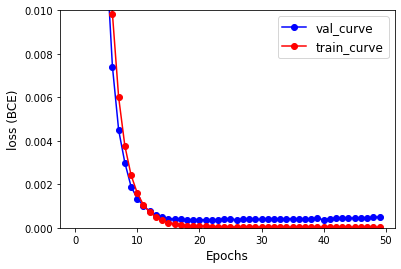

In [138]:
%matplotlib inline
epochs = range(num_epochs)
plt.figure()
plt.plot(epochs, val_loss,'bo-', label = 'val_curve')
plt.plot(epochs,train_loss,'ro-', label = 'train_curve')
plt.ylim([0,0.01])
plt.xlabel('Epochs', fontsize= 12)
plt.ylabel('loss (BCE)', fontsize = 12)
plt.legend(fontsize = 12)

Inference using the trained model.

In [143]:
PATH='saved_model/Epoch40.pth'
model.load_state_dict(torch.load(PATH))
model.eval()

Unet(
  (encoder): Encoder(
    (enc_blocks): ModuleList(
      (0): Block(
        (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu1): ReLU()
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu2): ReLU()
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Block(
        (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu1): ReLU()
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu2): ReLU()
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): Block(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1

Plot the figures in three columns: original image, gt mask and predicted mask. For illustration purpose, inference is shown on the whole collection (training data + val data).

Current patient ID = LIDC-IDRI-0079
Loading dicom files ... This may take a moment.


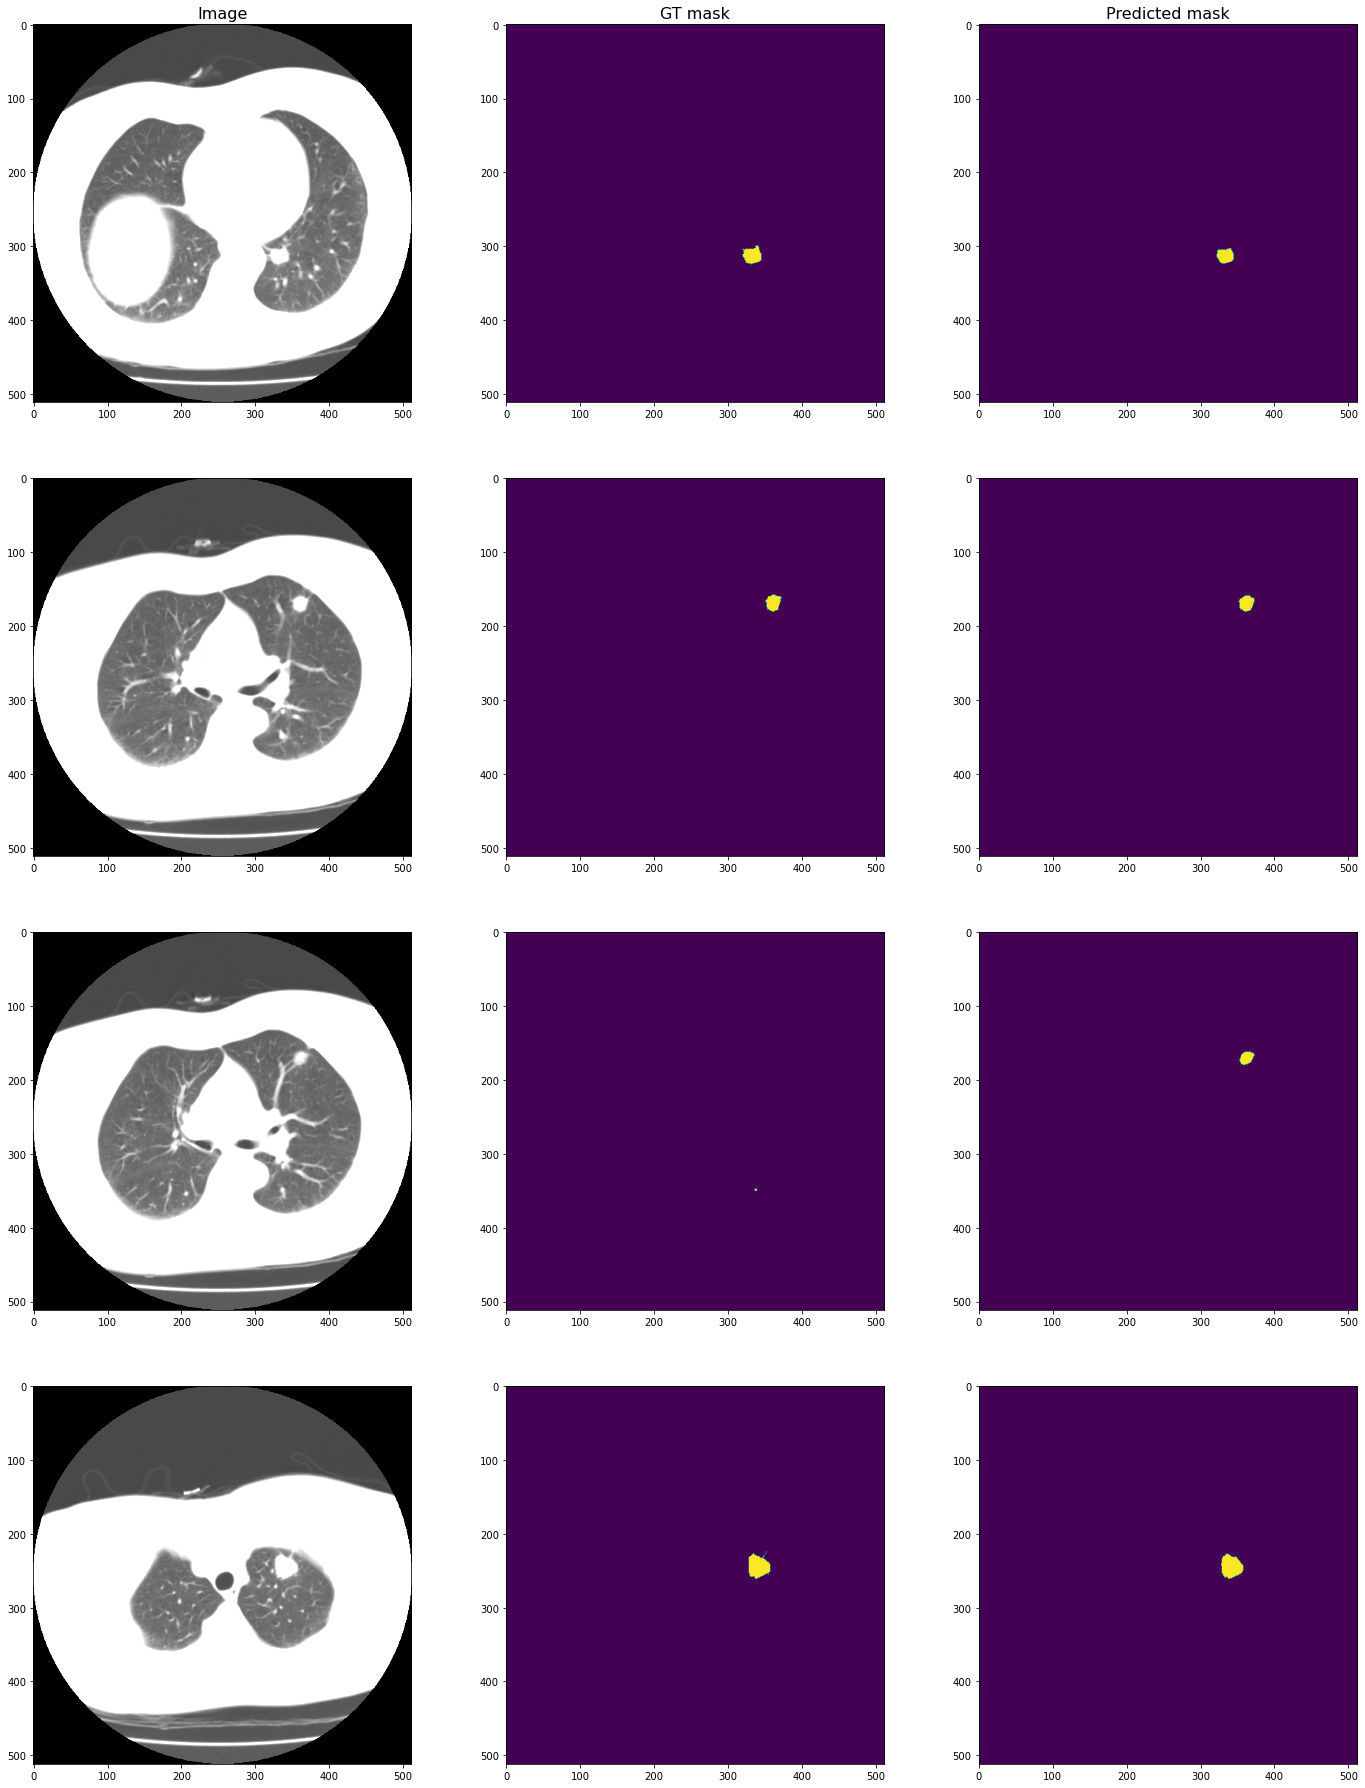

In [149]:
%matplotlib inline

cohort = data_folder
patient_list = os.listdir(cohort)
patient_select = 0

print ("Current patient ID =", patient_list[patient_select])

scan = pl.query(pl.Scan).filter(pl.Scan.patient_id.in_(patient_list))
nodules_annotation = scan[patient_select].cluster_annotations()
vol = scan[patient_select].to_volume()

cmask_CT = []
cbbox_CT = []
masks_CT = []
for nodule_idx, nodule in enumerate(nodules_annotation):
    cmask, cbbox, masks = consensus(nodule)
    cmask_CT.append(cmask)
    cbbox_CT.append(cbbox)
    masks_CT.append(masks)   

nodule_num = len(cmask_CT)
plt.figure(figsize=(8*3,8*nodule_num))
for i in range(nodule_num):
    cmask = cmask_CT[i]
    cbbox = cbbox_CT[i]
    masks = masks_CT[i]
    k = int(0.5*(cbbox[2].stop - cbbox[2].start))
    k_slice = k + cbbox[2].start
    plt.subplot(nodule_num,3,1+i*3)
    plt.imshow(vol[:,:,k_slice],cmap='gray')
    plt.clim(vmin=-1350,vmax=-150)
    if i==0:
        plt.title('Image',fontsize=16)
    
    plt.subplot(nodule_num,3,2+i*3)
    CT_mask = np.zeros_like(vol)
    CT_mask[cbbox] = cmask
    plt.imshow(CT_mask[:,:,k_slice])
    if i==0:
        plt.title('GT mask',fontsize=16)

    plt.subplot(nodule_num,3,3+i*3)
    image = vol[:,:,k_slice].astype('float32')
    image -= np.mean(image)
    image /= np.std(image)
    image = torch.from_numpy(image[np.newaxis,np.newaxis,:]).to(device)
    mask_pre = torch.sigmoid(model(image)).detach().cpu().numpy()
    mask_pre = np.squeeze(mask_pre)
  #  print(np.max(mask_pre), np.min(mask_pre))
  #  print(np.max(CT_mask[:,:,k_slice]), np.min(CT_mask[:,:,k_slice]))
    mask_pre = np.where(mask_pre>0.5, 1,0)
    plt.imshow(mask_pre)
    if i==0:
        plt.title('Predicted mask',fontsize=16)
   

#### Supplement material: 

#### Malignancy information is also collected for the labelled nodules, which can be used to prepare datasets for a cancer classification task.

In [9]:
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id.in_(patient_list)

In [15]:
scan[1].cluster_annotations()

[[Annotation(id=16,scan_id=2),
  Annotation(id=18,scan_id=2),
  Annotation(id=20,scan_id=2),
  Annotation(id=22,scan_id=2)],
 [Annotation(id=15,scan_id=2)],
 [Annotation(id=14,scan_id=2),
  Annotation(id=17,scan_id=2),
  Annotation(id=19,scan_id=2),
  Annotation(id=21,scan_id=2)]]

In [129]:
scan[1].annotations

[Annotation(id=14,scan_id=2),
 Annotation(id=15,scan_id=2),
 Annotation(id=16,scan_id=2),
 Annotation(id=17,scan_id=2),
 Annotation(id=18,scan_id=2),
 Annotation(id=19,scan_id=2),
 Annotation(id=20,scan_id=2),
 Annotation(id=21,scan_id=2),
 Annotation(id=22,scan_id=2)]

In [152]:
for i in range(len(patient_list)):
    print ("Patient:",i)
    for j in range(len(scan[i].annotations)):
        print ("annotation:",scan[i].annotations[j].Malignancy )

Patient: 0
annotation: Indeterminate
annotation: Indeterminate
annotation: Moderately Suspicious
annotation: Highly Suspicious
annotation: Moderately Suspicious
annotation: Moderately Suspicious
annotation: Highly Suspicious
annotation: Highly Unlikely
annotation: Highly Suspicious
annotation: Highly Suspicious
annotation: Indeterminate
annotation: Indeterminate
annotation: Indeterminate
Patient: 1
annotation: Highly Suspicious
annotation: Moderately Unlikely
annotation: Highly Suspicious
annotation: Indeterminate
annotation: Moderately Unlikely
annotation: Moderately Suspicious
annotation: Indeterminate
annotation: Moderately Unlikely
annotation: Indeterminate
Patient: 2
annotation: Indeterminate
annotation: Indeterminate
annotation: Highly Unlikely
annotation: Indeterminate
Patient: 3
annotation: Highly Unlikely
annotation: Indeterminate
Patient: 4
annotation: Moderately Unlikely
annotation: Indeterminate
annotation: Highly Unlikely
annotation: Highly Unlikely
annotation: Highly Unli